In [2]:
import os
import gc
from glob import glob
from pathlib import Path
from datetime import datetime

import numpy as np
import pandas as pd
import polars as pl

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedGroupKFold
from sklearn.base import BaseEstimator, ClassifierMixin

import lightgbm as lgb

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
class VotingModel(BaseEstimator, ClassifierMixin):
    def __init__(self, estimators):
        super().__init__()
        self.estimators = estimators
        
    def fit(self, X, y=None):
        return self
    
    def predict(self, X):
        y_preds = [estimator.predict(X) for estimator in self.estimators]
        return np.mean(y_preds, axis=0)
    
    def predict_proba(self, X):
        y_preds = [estimator.predict_proba(X) for estimator in self.estimators]
        return np.mean(y_preds, axis=0)

In [4]:
class Pipeline:
    @staticmethod
    def set_table_dtypes(df):
        for col in df.columns:
            if col in ["case_id", "WEEK_NUM", "num_group1", "num_group2"]:
                df = df.with_columns(pl.col(col).cast(pl.Int32))
            elif col in ["date_decision"]:
                df = df.with_columns(pl.col(col).cast(pl.Date))
            elif col[-1] in ("P", "A"):
                df = df.with_columns(pl.col(col).cast(pl.Float64))
            elif col[-1] in ("M",):
                df = df.with_columns(pl.col(col).cast(pl.String))
            elif col[-1] in ("D",):
                df = df.with_columns(pl.col(col).cast(pl.Date))            

        return df
    
    @staticmethod
    def handle_dates(df):
        for col in df.columns:
            if col[-1] in ("D",):
                df = df.with_columns(pl.col(col) - pl.col("date_decision"))
                df = df.with_columns(pl.col(col).dt.total_days())
                df = df.with_columns(pl.col(col).cast(pl.Float32))
                
        df = df.drop("date_decision", "MONTH")

        return df
    
    @staticmethod
    def filter_cols(df):
        for col in df.columns:
            if col not in ["target", "case_id", "WEEK_NUM"]:
                isnull = df[col].is_null().mean()

                if isnull > 0.95:
                    df = df.drop(col)

        for col in df.columns:
            if (col not in ["target", "case_id", "WEEK_NUM"]) & (df[col].dtype == pl.String):
                freq = df[col].n_unique()

                if (freq == 1) | (freq > 200):
                    df = df.drop(col)

        return df

In [5]:
class Aggregator:
    @staticmethod
    def num_expr(df):
        cols = [col for col in df.columns if col[-1] in ("P", "A")]

        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols]

        return expr_max

    @staticmethod
    def date_expr(df):
        cols = [col for col in df.columns if col[-1] in ("D",)]

        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols]

        return expr_max

    @staticmethod
    def str_expr(df):
        cols = [col for col in df.columns if col[-1] in ("M",)]
        
        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols]

        return expr_max

    @staticmethod
    def other_expr(df):
        cols = [col for col in df.columns if col[-1] in ("T", "L")]
        
        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols]

        return expr_max
    
    @staticmethod
    def count_expr(df):
        cols = [col for col in df.columns if "num_group" in col]

        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols]

        return expr_max

    @staticmethod
    def get_exprs(df):
        exprs = Aggregator.num_expr(df) + \
                Aggregator.date_expr(df) + \
                Aggregator.str_expr(df) + \
                Aggregator.other_expr(df) + \
                Aggregator.count_expr(df)

        return exprs

In [6]:
def read_file(path, depth=None):
    df = pl.read_parquet(path)
    df = df.pipe(Pipeline.set_table_dtypes)
    
    if depth in [1, 2]:
        df = df.group_by("case_id").agg(Aggregator.get_exprs(df))
    
    return df

def read_files(regex_path, depth=None):
    chunks = []
    for path in glob(str(regex_path)):
        df = pl.read_parquet(path)
        df = df.pipe(Pipeline.set_table_dtypes)
        
        if depth in [1, 2]:
            df = df.group_by("case_id").agg(Aggregator.get_exprs(df))
        
        chunks.append(df)
        
    df = pl.concat(chunks, how="vertical_relaxed")
    df = df.unique(subset=["case_id"])

    return df
    

In [7]:
def feature_eng(df_base, depth_0, depth_1, depth_2):
    df_base = (
        df_base
        .with_columns(
            month_decision = pl.col("date_decision").dt.month(),
            weekday_decision = pl.col("date_decision").dt.weekday(),
        )
    )
        
    for i, df in enumerate(depth_0 + depth_1 + depth_2):
        df_base = df_base.join(df, how="left", on="case_id", suffix=f"_{i}")
        
    df_base = df_base.pipe(Pipeline.handle_dates)
    
    return df_base

In [8]:
def to_pandas(df_data, cat_cols=None):
    df_data = df_data.to_pandas()
    
    if cat_cols is None:
        cat_cols = list(df_data.select_dtypes("object").columns)
    
    df_data[cat_cols] = df_data[cat_cols].astype("category")
    
    return df_data, cat_cols

In [9]:

##ROOT            = Path("/kaggle/input/home-credit-credit-risk-model-stability")
##TRAIN_DIR       = ROOT / "parquet_files" / "train"
##TEST_DIR        = ROOT / "parquet_files" / "test"

from pathlib import Path

TRAIN_DIR = Path("../parquet_files/train")
TEST_DIR = Path("../parquet_files/test")




In [10]:
data_store = {
    "df_base": read_file(TRAIN_DIR / "train_base.parquet"),
    "depth_0": [
        read_file(TRAIN_DIR / "train_static_cb_0.parquet"),
        read_files(TRAIN_DIR / "train_static_0_*.parquet"),
    ],
    "depth_1": [
        read_files(TRAIN_DIR / "train_applprev_1_*.parquet", 1),
        read_file(TRAIN_DIR / "train_tax_registry_a_1.parquet", 1),
        read_file(TRAIN_DIR / "train_tax_registry_b_1.parquet", 1),
        read_file(TRAIN_DIR / "train_tax_registry_c_1.parquet", 1),
        read_files(TRAIN_DIR / "train_credit_bureau_a_1_*.parquet", 1),
        read_file(TRAIN_DIR / "train_credit_bureau_b_1.parquet", 1),
        read_file(TRAIN_DIR / "train_other_1.parquet", 1),
        read_file(TRAIN_DIR / "train_person_1.parquet", 1),
        read_file(TRAIN_DIR / "train_deposit_1.parquet", 1),
        read_file(TRAIN_DIR / "train_debitcard_1.parquet", 1),
    ],
    "depth_2": [
        read_file(TRAIN_DIR / "train_credit_bureau_b_2.parquet", 2),
        read_files(TRAIN_DIR / "train_credit_bureau_a_2_*.parquet", 2),
    ]
}

In [11]:
df_train = feature_eng(**data_store)

print("train data shape:\t", df_train.shape)

train data shape:	 (1526659, 472)


In [12]:
data_store = {
    "df_base": read_file(TEST_DIR / "test_base.parquet"),
    "depth_0": [
        read_file(TEST_DIR / "test_static_cb_0.parquet"),
        read_files(TEST_DIR / "test_static_0_*.parquet"),
    ],
    "depth_1": [
        read_files(TEST_DIR / "test_applprev_1_*.parquet", 1),
        read_file(TEST_DIR / "test_tax_registry_a_1.parquet", 1),
        read_file(TEST_DIR / "test_tax_registry_b_1.parquet", 1),
        read_file(TEST_DIR / "test_tax_registry_c_1.parquet", 1),
        read_files(TEST_DIR / "test_credit_bureau_a_1_*.parquet", 1),
        read_file(TEST_DIR / "test_credit_bureau_b_1.parquet", 1),
        read_file(TEST_DIR / "test_other_1.parquet", 1),
        read_file(TEST_DIR / "test_person_1.parquet", 1),
        read_file(TEST_DIR / "test_deposit_1.parquet", 1),
        read_file(TEST_DIR / "test_debitcard_1.parquet", 1),
    ],
    "depth_2": [
        read_file(TEST_DIR / "test_credit_bureau_b_2.parquet", 2),
        read_files(TEST_DIR / "test_credit_bureau_a_2_*.parquet", 2),
    ]
}

In [13]:
df_test = feature_eng(**data_store)

print("test data shape:\t", df_test.shape)

test data shape:	 (10, 471)


In [14]:
df_train = df_train.pipe(Pipeline.filter_cols)
df_test = df_test.select([col for col in df_train.columns if col != "target"])

print("train data shape:\t", df_train.shape)
print("test data shape:\t", df_test.shape)

train data shape:	 (1526659, 361)
test data shape:	 (10, 360)


In [15]:
df_train, cat_cols = to_pandas(df_train)
df_test, cat_cols = to_pandas(df_test, cat_cols)

In [16]:

del data_store
gc.collect()

0

In [17]:
print("Train is duplicated:\t", df_train["case_id"].duplicated().any())
print("Train Week Range:\t", (df_train["WEEK_NUM"].min(), df_train["WEEK_NUM"].max()))

print()

print("Test is duplicated:\t", df_test["case_id"].duplicated().any())
print("Test Week Range:\t", (df_test["WEEK_NUM"].min(), df_test["WEEK_NUM"].max()))

Train is duplicated:	 False
Train Week Range:	 (0, 91)

Test is duplicated:	 False
Test Week Range:	 (100, 100)


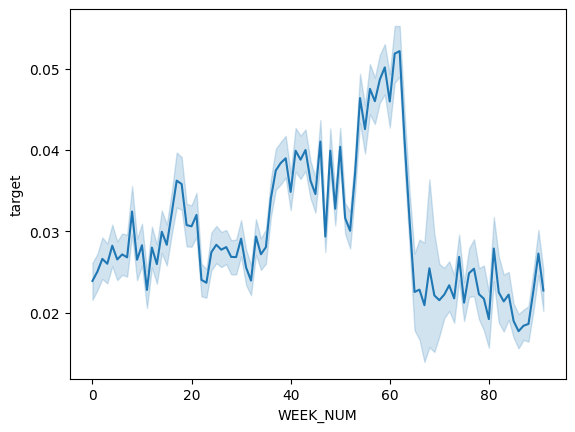

In [18]:
sns.lineplot(
    data=df_train,
    x="WEEK_NUM",
    y="target",
)
plt.show()

In [19]:
X = df_train.drop(columns=["target", "case_id", "WEEK_NUM"])
y = df_train["target"]
weeks = df_train["WEEK_NUM"]

cv = StratifiedGroupKFold(n_splits=5, shuffle=False)

params = {
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "auc",
    "max_depth": 8,
    "learning_rate": 0.05,
    "n_estimators": 1000,
    "colsample_bytree": 0.8, 
    "colsample_bynode": 0.8,
    "verbose": -1,
    "random_state": 42,
    "device": "gpu",
}

fitted_models = []

for idx_train, idx_valid in cv.split(X, y, groups=weeks):
    X_train, y_train = X.iloc[idx_train], y.iloc[idx_train]
    X_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid]

    model = lgb.LGBMClassifier(**params)
    model.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        callbacks=[lgb.log_evaluation(100), lgb.early_stopping(100)]
    )

    fitted_models.append(model)

model = VotingModel(fitted_models)

Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.837898
[200]	valid_0's auc: 0.847093
[300]	valid_0's auc: 0.850332
[400]	valid_0's auc: 0.85174
[500]	valid_0's auc: 0.85243
[600]	valid_0's auc: 0.852733
[700]	valid_0's auc: 0.852942
[800]	valid_0's auc: 0.853286
[900]	valid_0's auc: 0.85349
[1000]	valid_0's auc: 0.853716
Did not meet early stopping. Best iteration is:
[998]	valid_0's auc: 0.853728
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.838563
[200]	valid_0's auc: 0.847118
[300]	valid_0's auc: 0.850066
[400]	valid_0's auc: 0.851261
[500]	valid_0's auc: 0.85193
[600]	valid_0's auc: 0.85238
[700]	valid_0's auc: 0.852836
[800]	valid_0's auc: 0.853004
[900]	valid_0's auc: 0.853231
[1000]	valid_0's auc: 0.853354
Did not meet early stopping. Best iteration is:
[999]	valid_0's auc: 0.853358
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.843069
[200]	valid_0's auc: 0.852453
[

In [20]:
X_test = df_test.drop(columns=["WEEK_NUM"])
X_test = X_test.set_index("case_id")

y_pred = pd.Series(model.predict_proba(X_test)[:, 1], index=X_test.index)

In [21]:
df_subm = pd.read_csv("sample_submission.csv")
df_subm = df_subm.set_index("case_id")

df_subm["score"] = y_pred

In [22]:
print("Check null: ", df_subm["score"].isnull().any())

df_subm.head()

Check null:  False


,score
case_id,
57543,0.005374
57549,0.074334
57551,0.004932
57552,0.015758
57569,0.125186


In [23]:
df_subm.to_csv("submission.csv")